# Dependencies

In [1]:
import torch
import functools 

from osmnx_utils import gps_to_meters

# Overview
The RasMSELoss class is used to train a neural network predicting values at gps coordinates with labels available at only a few coordinates. The reasoning is that prediction at coordinates close to coordinates of labels should be close in value to those labels. Specifically, we assume that the confidence in the similarity to those labels decreases with the distance squared (optionally dropping off completely after a set distance).

In [2]:
def dists(x: torch.tensor, y: torch.tensor, /) -> torch.tensor: 
    """
    Compute pair-wise distances between two arrays of gps coordinates (longitude, latitude)
    in meters. 
    """
    # Choose the scale at the average latitude 
    scale = gps_to_meters(x[:, 1].mean())
    return torch.linalg.norm(
        (x - y.view(-1, 1, 2)) * torch.tensor(scale), 
        axis=-1, 
    )


def dists_min(fro: torch.tensor, to: torch.tensor) -> torch.tensor:
    """
    Compute minimum distances from all elements of fro to any element of to.
    """
    return dists(fro, to).min(axis=0)[0]

In [3]:
class RadMSELoss(torch.nn.MSELoss):
    """
    Compute the mean squared error of the predictions at coordinates within radius distance to the 
    coordinates of the labels. Optionally, the mean squared error is weighted by the squared inverse of the 
    minimum distance to any label.
    """
    
    def __init__(self, preds_gps: torch.Tensor, labels_gps: torch.Tensor, radius: float, 
                 weighted: bool = True, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        """
        preds_gps: coordinates of the predictions. 
        labels_gps: coordinates of the labels.
        radius: maximum distance from any label for a prediction to be included in the loss calculation.
        weighted: If true, the mean squared error will be weighted by the squared inverse of the minimum 
        distance to any label.
        """
        super().__init__(size_average=size_average, reduce=reduce, reduction=reduction)
        self.radius = radius 
        self.dists = dists_min(fro=preds_gps, to=labels_gps)
        self.weight = torch.pow(self.dists, -2)[self.indices_in_radius] if weighted is True else 1
        
    @functools.cached_property
    def indices_in_radius(self) -> torch.Tensor:
        """
        Returns indices of elements in self.dists which are no greater than self.radius.
        """
        return torch.ones(self.dists.shape, dtype=torch.long) if self.radius is None \
    else (self.dists <= self.radius).nonzero().type(torch.long).squeeze()
    
    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute the loss. 
        """
        return torch.mean(
            (input[self.indices_in_radius] - target[self.indices_in_radius]).pow(2) * self.weight
        )

# Example
We will create three sets of concentric washers, where each washer contains predictions of different values. We will see that the further away from the label we are, the lower the influence of the predictides values; however, if the values are very large, they can still sway the loss, even if far away. 

In [4]:
import pandas as pd

from dataset import Dataset 
from matplotlib import pyplot as plt

In [5]:
# n points
n = 5000
# value of the input
v = 100
# scaling factor to gps for reasonable radius values
scale = 100

# thetas (angles around the center)
t = torch.rand(n).view(-1, 1) * 2 * torch.pi
# distances from the center
r = torch.rand(n).view(-1, 1).pow(1/2) / scale
# coordinates 
p = torch.cat([torch.cos(t), torch.sin(t)], dim=1) * r

input = torch.ones(n) * v

# first set of station coordinates and targets
s1 = torch.Tensor([[0, 0]])
target1 = v + (p - s1).pow(2).sum(dim=-1) * scale**2 * v

# second set of station coordinates and targets
s2 = torch.Tensor([[-0.005, 0.0], [0.005, 0.0]])
target2 = v + (p - s2.reshape(2, 1, 2)).pow(2).sum(dim=-1).min(dim=0)[0] * scale**2 * v

Example with one station

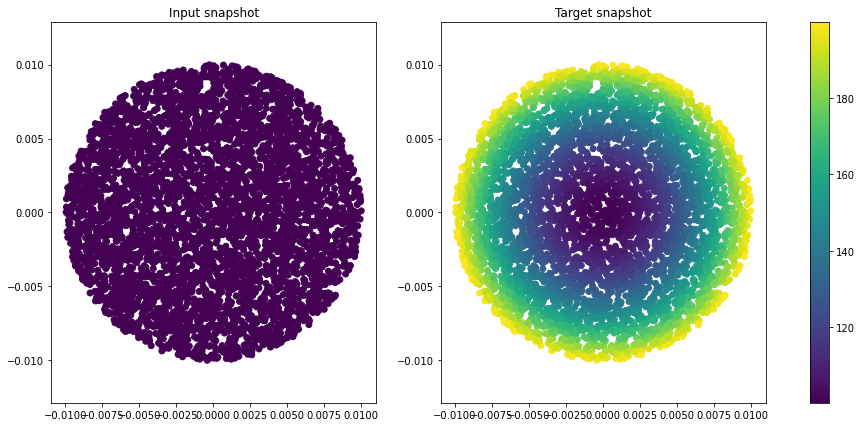

In [6]:
fig, (ax_input, ax_target) = plt.subplots(1, 2, figsize=(16, 7))

sctr = ax_input.scatter(*p.T, c=input)
ax_input.axis('equal')
ax_input.set_title("Input snapshot")

sctr = ax_target.scatter(*p.T, c=target1)
ax_target.axis('equal')
ax_target.set_title("Target snapshot")

plt.colorbar(sctr, ax=[ax_input, ax_target]);

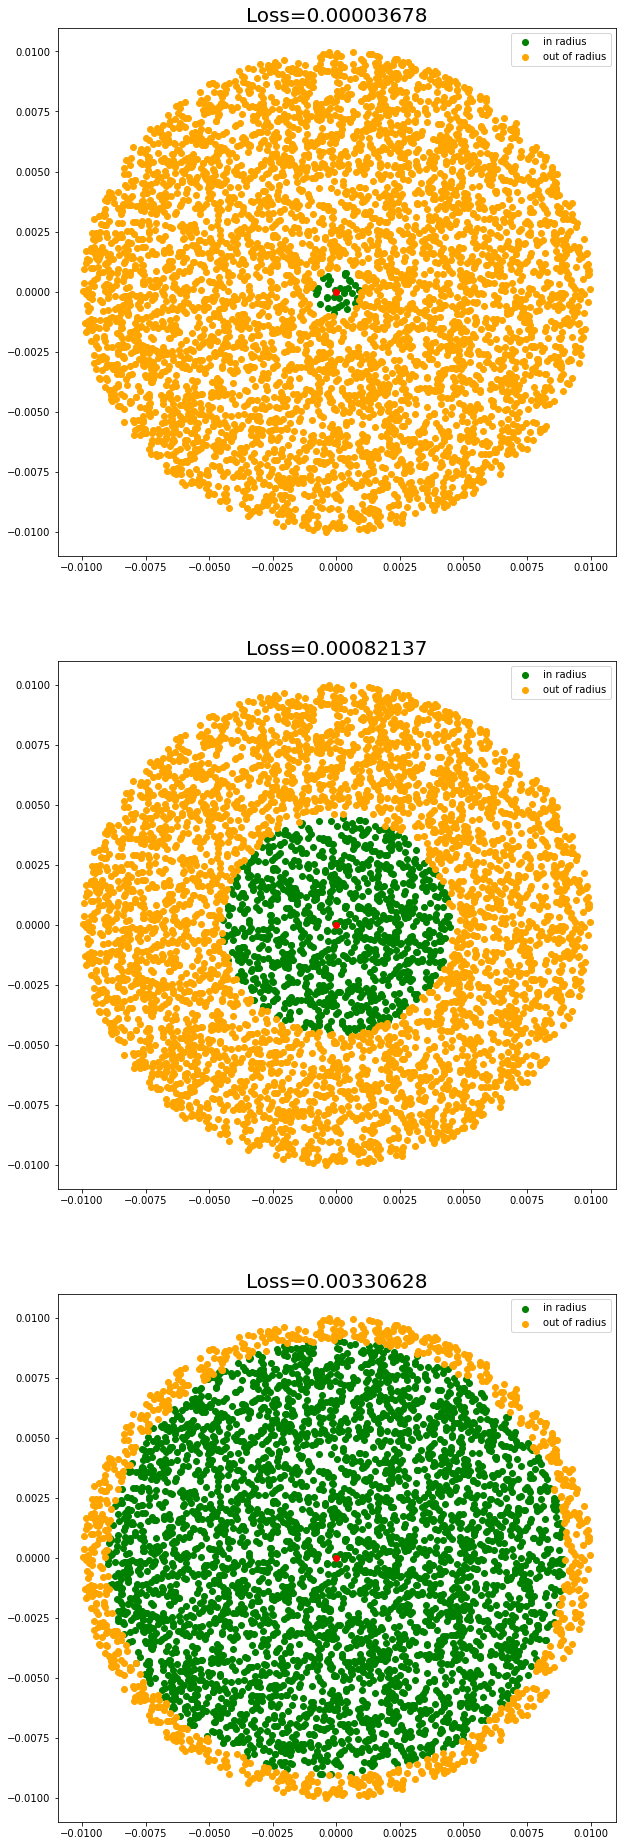

In [8]:
radii = (100, 500, 1000)
fig, axes = plt.subplots(len(radii), 1, figsize=(10, 11*len(radii)))

for radius, ax in zip(radii, axes):
    loss = RadMSELoss(preds_gps=p, labels_gps=s1, radius=radius)
    mask = torch.isin(torch.arange(n), loss.indices_in_radius)
    
    ax.scatter(*p[mask].T, c='green', label='in radius')
    ax.scatter(*p[~mask].T, c='orange', label='out of radius')
    ax.scatter(*s1.T, c='r')
    ax.legend()
    ax.set_title(f"Loss={loss(input, target1):.8f}", fontsize=20);

Example with multiple stations. 

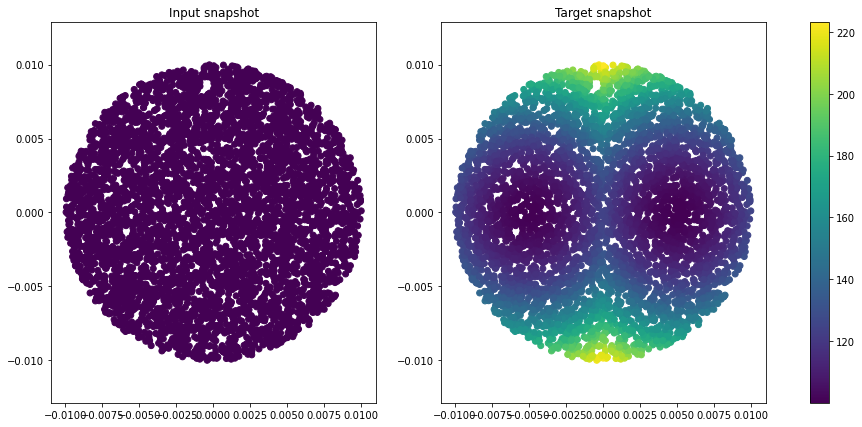

In [9]:
fig, (ax_input, ax_target) = plt.subplots(1, 2, figsize=(16, 7))

sctr = ax_input.scatter(*p.T, c=input)
ax_input.axis('equal')
ax_input.set_title("Input snapshot")

sctr = ax_target.scatter(*p.T, c=target2)
ax_target.axis('equal')
ax_target.set_title("Target snapshot")

plt.colorbar(sctr, ax=[ax_input, ax_target]);

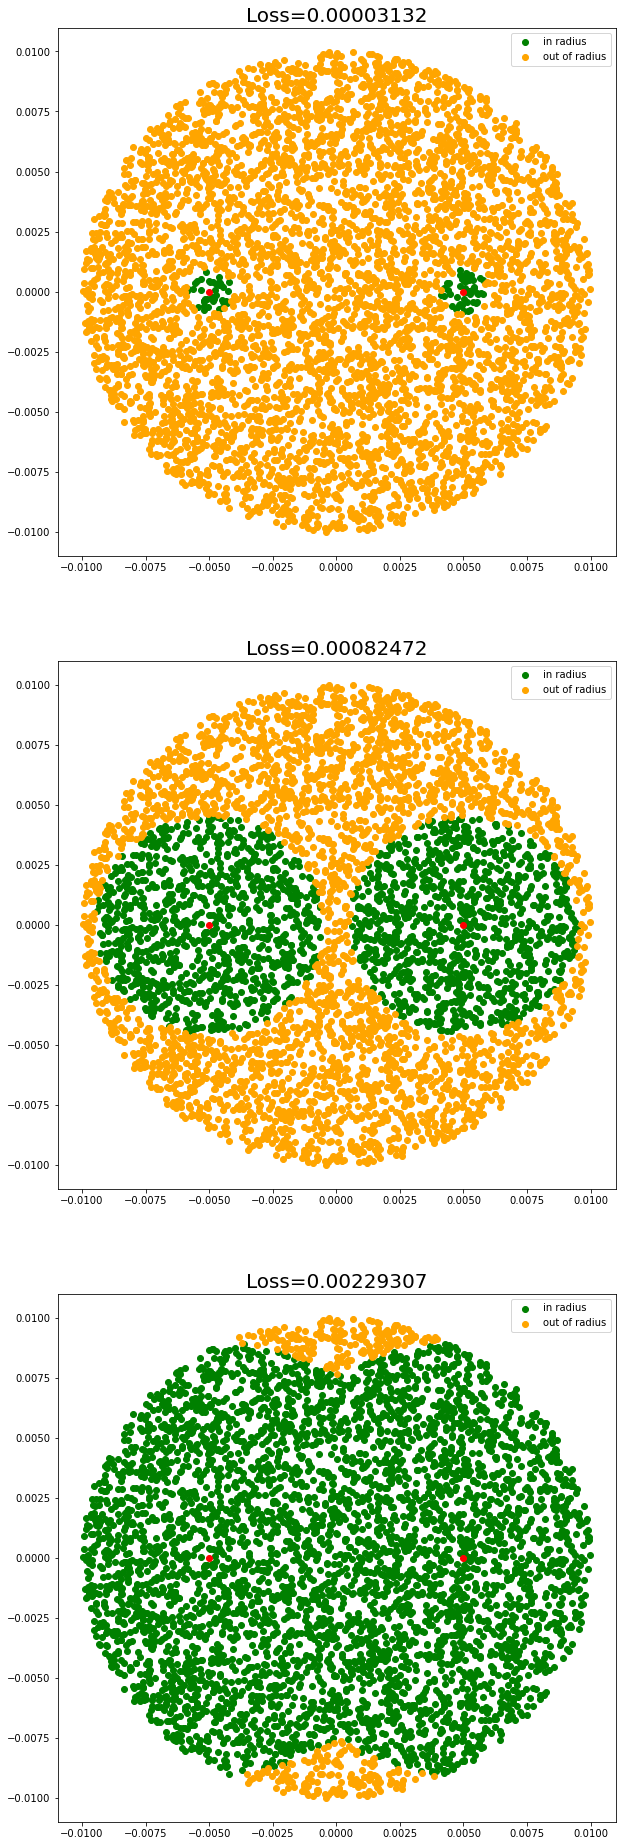

In [10]:
radii = (100, 500, 1000)
fig, axes = plt.subplots(len(radii), 1, figsize=(10, 11*len(radii)))

for radius, ax in zip(radii, axes):
    loss = RadMSELoss(preds_gps=p, labels_gps=s2, radius=radius)
    mask = torch.isin(torch.arange(n), loss.indices_in_radius)
    
    ax.scatter(*p[mask].T, c='green', label='in radius')
    ax.scatter(*p[~mask].T, c='orange', label='out of radius')
    ax.scatter(*s2.T, c='r')
    ax.legend()
    ax.set_title(f"Loss={loss(input, target2):.8f}", fontsize=20);